In [19]:
import numpy as np
import pyodbc
import pandas as pd
from apriori_python.apriori_algo import *
from apriori_python.utils import *
import ast

In [2]:
# # may need to change the input format depends on the ETL
# df = pd.read_csv('output_csv/table1.csv')
# # res = df['Item'].tolist()
# itemSetList = []
# # |D| = 31465
# for value in df['Item']:
#     val = ast.literal_eval(value)
#     itemSetList.append(val)

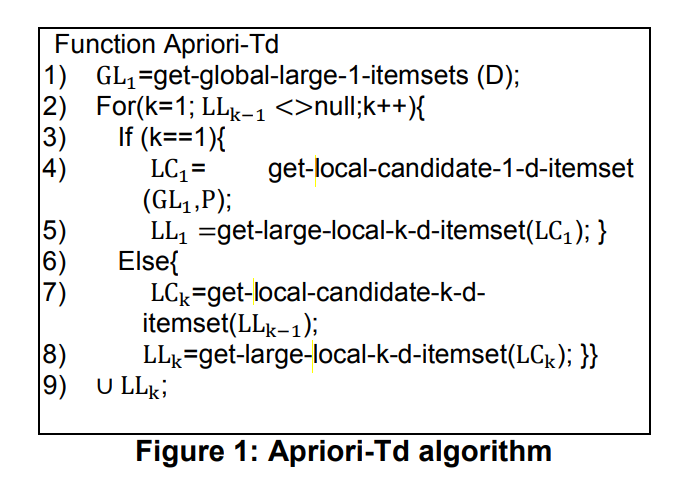

## Step 1: get global large 1 itemsets

In [22]:
itemSetList = [['eggs', 'bacon', 'soup'],
                ['eggs', 'bacon', 'apple'],
                ['soup', 'bacon', 'banana']]
minSup = 0.01

# freqItemSet, rules = apriori(itemSetList_0, minSup=0.01, minConf=0.5)
C1ItemSet = getItemSetFromList(itemSetList)

globalItemSetWithSup = defaultdict(int)

L1ItemSet = getAboveMinSup(C1ItemSet, itemSetList, minSup, globalItemSetWithSup)

print(L1ItemSet)


{frozenset({'bacon'}), frozenset({'apple'}), frozenset({'banana'}), frozenset({'soup'}), frozenset({'eggs'})}
